In [97]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from minisom import MiniSom
from math import floor

In [98]:
df = pd.read_csv("stars.csv")
X_train = df.drop(['Star type'], axis=1)

In [99]:
numeric_attributes = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
categorical_attributes = ['Star color', 'Spectral Class']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="mean"))
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy="most_frequent"))
])

preprocessor = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, numeric_attributes),
    ('onehot', categorical_transformer, categorical_attributes)
])

kmeans = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler(feature_range=(0,1))),
    ('model', KMeans(n_clusters=6, random_state=42, n_init=10))
])

kmeans.fit(X_train)
labels = kmeans.named_steps['model'].labels_
preprocessed_X = kmeans.transform(X_train)
silhouette_avg = silhouette_score(preprocessed_X, labels)
inertia = kmeans.named_steps['model'].inertia_

# Print the silhouette and inertia coefficients
print("Silhouette Score:", silhouette_avg)
print("Inertia Coefficient:", inertia)

Silhouette Score: 0.634739188309546
Inertia Coefficient: 22.78263551625061


<AxesSubplot:xlabel='Temperature (K)', ylabel='Radius(R/Ro)'>

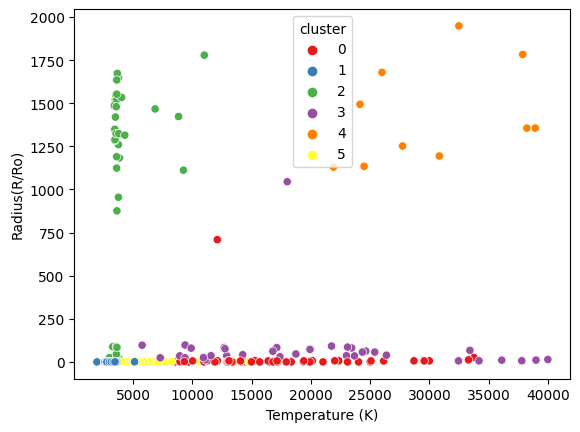

In [100]:
df['cluster'] = labels
sns.scatterplot(data=df,x='Temperature (K)',y='Radius(R/Ro)',hue='cluster',palette="Set1")

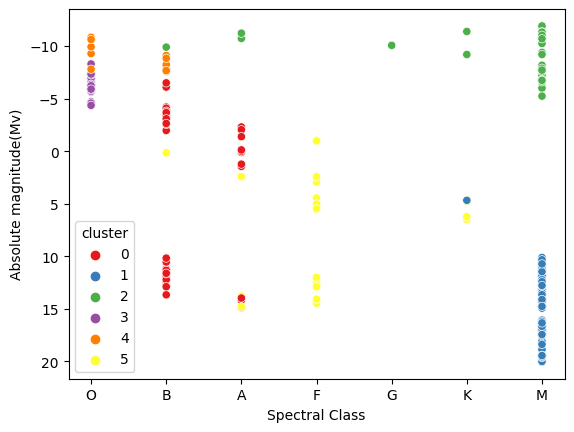

In [101]:
order = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
cat_type = pd.CategoricalDtype(categories=order, ordered=True)
df['Spectral Class'] = df['Spectral Class'].astype(cat_type)
ax = sns.scatterplot(data=df,x='Spectral Class',y='Absolute magnitude(Mv)',hue='cluster',palette="Set1",)
ax.invert_yaxis()

+ 0(RED) - A-type Main Sequence stars (Absolute magnitude: -3 to +2, Spectral class: A, Radius: ~1 Ro, Temperature: 7500-10000K)
+ 0(RED) - B-type Main Sequence stars (Absolute magnitude: -5 to -2, Spectral class: B, Radius: ~1 Ro, Temperature: >10000-30000K)
+ 3(PURPLE) - O-type Main Sequence (Absolute magnitude: -5 to -8, Spectral class: O, Radius: <100 Ro)
+ 5(YELLOW) - F-type Main Sequence (Absolute magnitude: -5 to -8, Spectral class: O, Radius: <100 Ro)
+ 5(YELLOW) - White Dwarves (Absolute magnitude: +10 to +15, Spectral class: F, Radius: <1 Ro)
+ 0(RED) - White Dwarves (Absolute magnitude: +10 to +15, Spectral class: B, Radius: <1 Ro, Temperature: >10000-30000K)
+ 1(BLUE) - Red Dwarves (Absolute magnitude: +13. Spectral class: M)
+ 1(BLUE) - Brown Dwarves (Absolute magnitude: +18. Spectral class: M)
+ 2(GREEN) - Red giants (Absolute magnitude: -7 to -9, Spectral class: M, Radius: 10-100 Ro) 
+ 2(GREEN) - Red supergiants (Absolute magnitude: -5 to -9, Spectral class: M, Radius: >1000 Ro)
+ 4(ORANGE) - Hypergiants (Absolute magnitude: -10 to -5, Radius: 1000 Ro, Temperature: >20000)

<AxesSubplot:xlabel='Star color', ylabel='Spectral Class'>

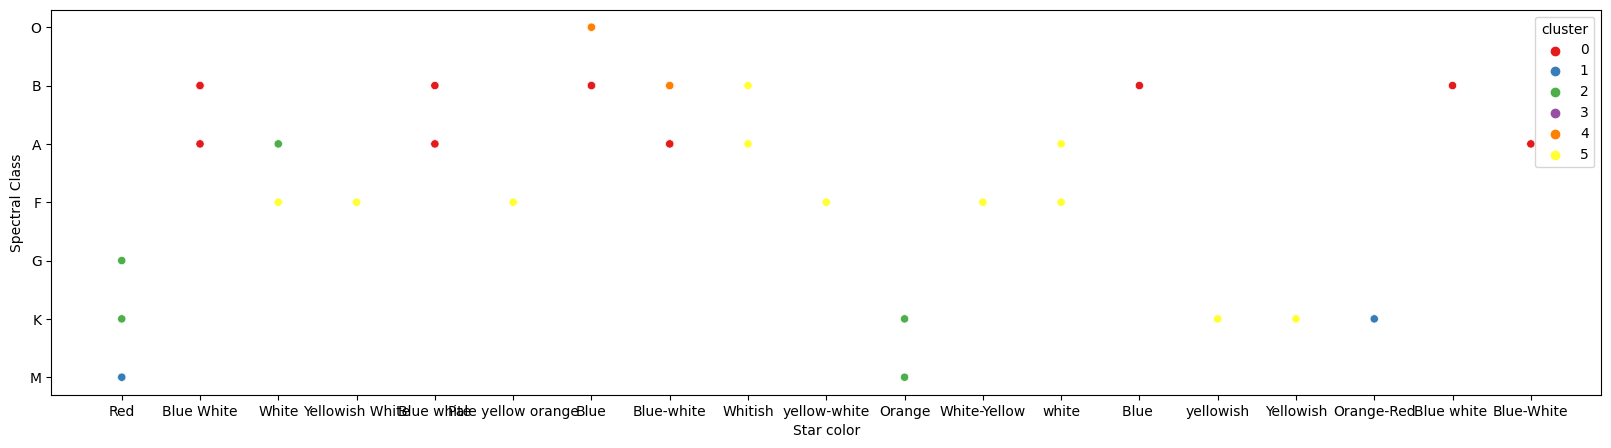

In [102]:
fig = plt.figure(figsize = (20,5))
ax = fig.gca()

sns.scatterplot(data=df,x='Star color',y='Spectral Class',hue='cluster',palette="Set1",ax=ax)

Optimal learning rate:  0.85
Max silhouette Score: 0.4708557861928628
Max silhouette score coordinates: [ 5 5 ]


Text(50.722222222222214, 0.5, 'y')

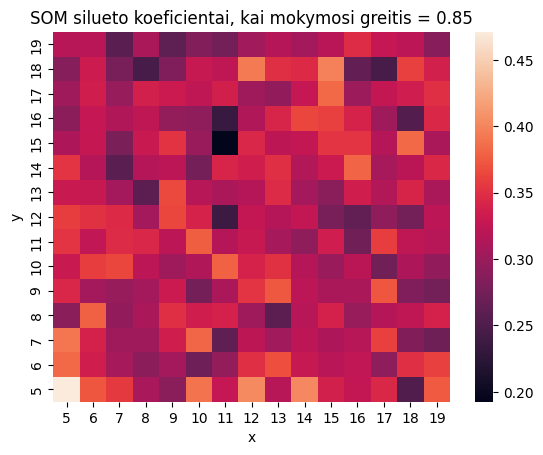

In [103]:
numeric_attributes = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
categorical_attributes = ['Star color', 'Spectral Class']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="mean"))
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy="most_frequent"))
])

preprocessor = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, numeric_attributes),
    ('ordinal', categorical_transformer, categorical_attributes)
])

class MiniSomWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, x=7, y=7, input_len=2, sigma=1.0, learning_rate=0.5,random_value=42):
        self.som = MiniSom(x, y, input_len, sigma=sigma, learning_rate=learning_rate, random_seed=random_value)
        self.x = x
        self.y = y

    def fit(self, X, y=None):
        self.som.train_random(X, 100)
        return self

    def transform(self, X, y=None):
        winners = np.array([self.som.winner(x) for x in X])
        return winners[:, 0] * self.y + winners[:, 1]
    
    def predict(self, X):
        winners = np.array([self.som.winner(x) for x in X])
        return winners[:, 0] * self.y + winners[:, 1]
    
    def winners(self, X):
        return np.array([self.som.winner(x) for x in X])
    
    def quantization_error(self, X):
        return self.som.quantization_error(X)
    
    def hit_map(self, X):
        hit_map = np.zeros((self.x, self.y))
        for x in X:
            w = self.som.winner(x)
            hit_map[w[0]][w[1]] += 1
        return hit_map
    def get_weights(self,X):
        return self.som.get_weights().reshape(-1, X.shape[1])
    
    def winner(self, x):
        return self.som.winner(x)

max_lr = None    
max_sil = -1
max_som = None
silhouettes = None
# for lr in range(10,100):
for lr in range(85,86):
    max_sil_it = -1
    max_som_it = None
    silhouettes_it = [[None for _ in range(15)] for _ in range(15)]
    q_errors_it = [[None for _ in range(15)] for _ in range(15)]
    for i in range(5,20):
        for j in range(5,20):
            som = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('model', MiniSomWrapper(input_len=6, x=i, y=j, learning_rate=lr/100))
            ])
            som.fit(X_train)
            labels = som.predict(X_train)
            preprocessed_X = som.named_steps['preprocessor'].transform(X_train)
            silhouette_avg = silhouette_score(preprocessed_X, labels)
            silhouettes_it[j-5][i-5] = silhouette_avg
            if silhouette_avg > max_sil_it:
                max_sil_it = silhouette_avg
                max_som_it = som
    if max_sil_it > max_sil:
        max_sil = max_sil_it
        max_som = max_som_it
        silhouettes = silhouettes_it
        max_lr = lr/100

silhouettes_flat = [item for sublist in silhouettes for item in sublist]
silhouette = max(silhouettes_flat)
idx = silhouettes_flat.index(silhouette)
print("Optimal learning rate: ", max_lr)
print("Max silhouette Score:", max_sil)
print("Max silhouette score coordinates: [", idx % 15 + 5, floor(idx / 15 + 5), "]")

ax = sns.heatmap(silhouettes,xticklabels=[i for i in range(5,20)],yticklabels=[i for i in range(5,20)])
ax.invert_yaxis()
ax.set_title('SOM silueto koeficientai, kai mokymosi greitis = 0.85')
ax.set_xlabel("x")
ax.set_ylabel("y")

0.4708557861928628


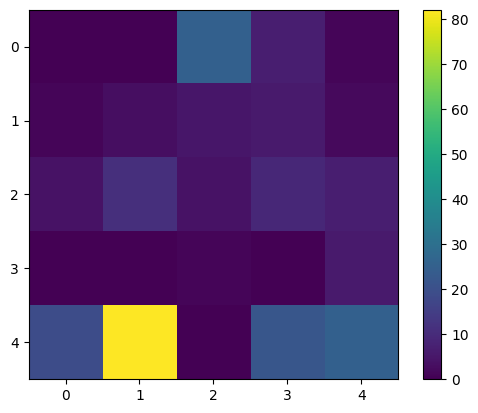

In [104]:
som = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', MiniSomWrapper(input_len=6, x=idx % 15 + 5, y=floor(idx / 15 + 5),learning_rate=max_lr))
        ])
som.fit(X_train)

labels = som.predict(X_train)
print(silhouette_score(preprocessed_X, labels))



hit_map = som.named_steps['model'].hit_map(preprocessed_X)
plt.imshow(hit_map, cmap='viridis')
plt.colorbar()
plt.show()

0.4329826513696746


<AxesSubplot:xlabel='Temperature (K)', ylabel='Radius(R/Ro)'>

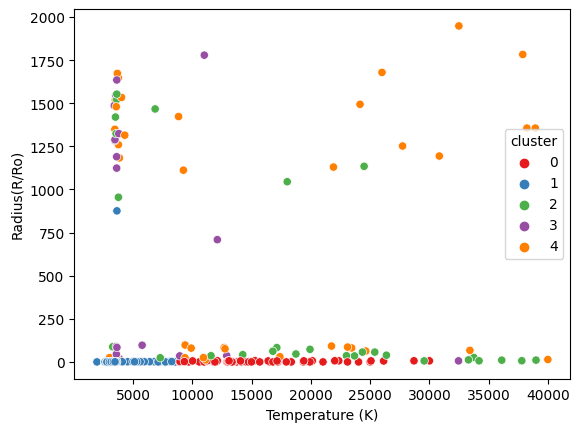

In [105]:
labels = som.named_steps['model'].predict(preprocessed_X)

cluster1_neurons = [2,3,4,7]
labels = [4 if x in cluster1_neurons else x for x in labels]

cluster2_neurons = [5,6,10,11]
labels = [3 if x in cluster2_neurons else x for x in labels]

cluster3_neurons = [8,9,12,13,14]
labels = [2 if x in cluster3_neurons else x for x in labels]

cluster4_neurons = [17,20,21]
labels = [1 if x in cluster4_neurons else x for x in labels]

cluster5_neurons = [19,23,24]
labels = [0 if x in cluster5_neurons else x for x in labels]

df['cluster'] = labels

print(silhouette_score(preprocessed_X, labels))

sns.scatterplot(data=df,x='Temperature (K)',y='Radius(R/Ro)',hue='cluster',palette="Set1")

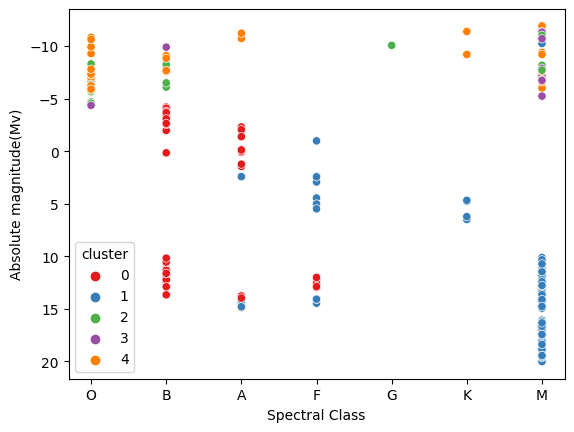

In [106]:
order = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
cat_type = pd.CategoricalDtype(categories=order, ordered=True)
df['Spectral Class'] = df['Spectral Class'].astype(cat_type)
ax = sns.scatterplot(data=df,x='Spectral Class',y='Absolute magnitude(Mv)',hue='cluster',palette="Set1",)
ax.invert_yaxis()

<AxesSubplot:xlabel='Star color', ylabel='Spectral Class'>

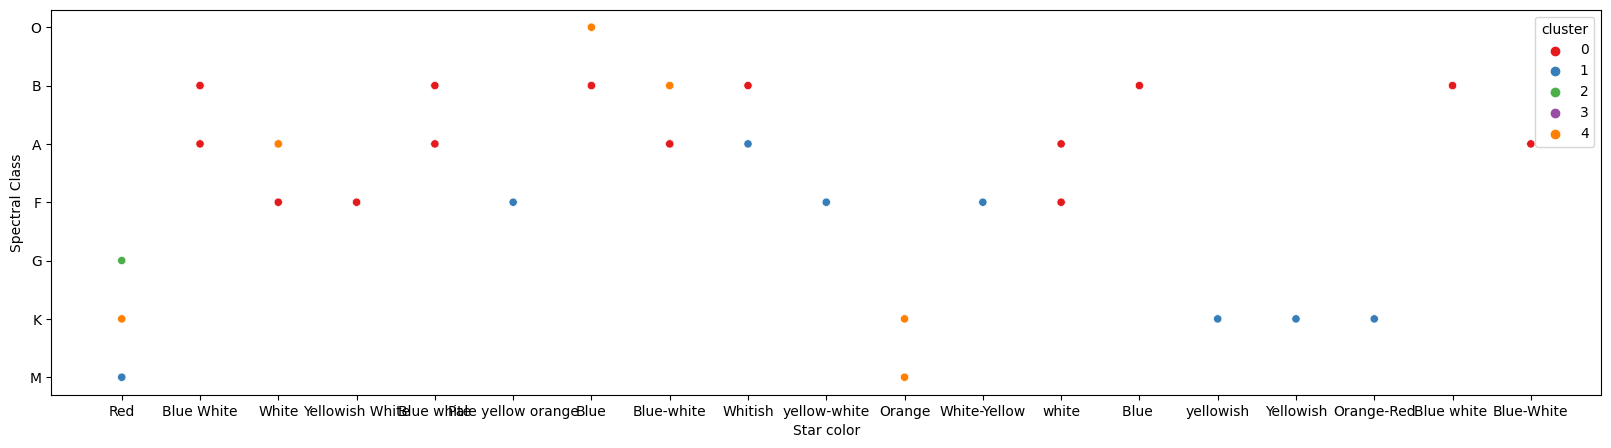

In [107]:
fig = plt.figure(figsize = (20,5))
ax = fig.gca()

sns.scatterplot(data=df,x='Star color',y='Spectral Class',hue='cluster',palette="Set1",ax=ax)

0.5769346542158357


c:\Users\karol\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<AxesSubplot:xlabel='Temperature (K)', ylabel='Radius(R/Ro)'>

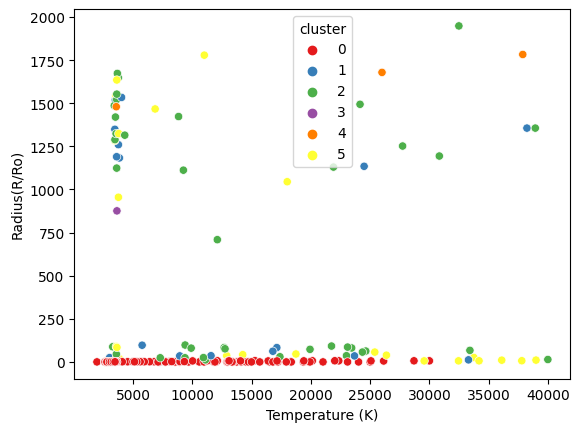

In [108]:
weights = som.named_steps['model'].get_weights(X_train)
kmeans = KMeans(n_clusters=6) 
clusters = kmeans.fit_predict(weights)

labels = som.named_steps['model'].predict(preprocessed_X)
for i in range(0,len(labels)):
    labels = [clusters[i] if x == i else x for x in labels]

df['cluster'] = labels

print(silhouette_score(preprocessed_X, labels))

sns.scatterplot(data=df,x='Temperature (K)',y='Radius(R/Ro)',hue='cluster',palette="Set1")

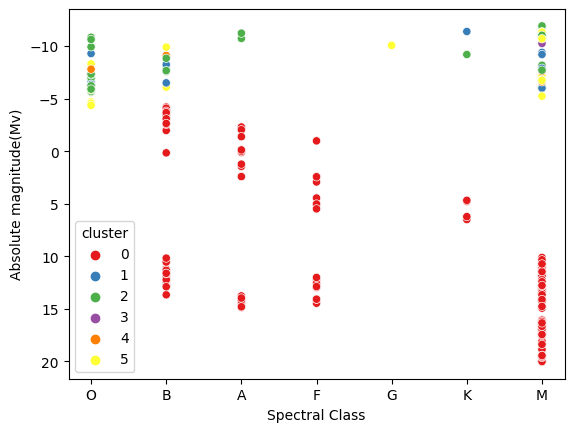

In [109]:
order = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
cat_type = pd.CategoricalDtype(categories=order, ordered=True)
df['Spectral Class'] = df['Spectral Class'].astype(cat_type)
ax = sns.scatterplot(data=df,x='Spectral Class',y='Absolute magnitude(Mv)',hue='cluster',palette="Set1",)
ax.invert_yaxis()

<AxesSubplot:xlabel='Star color', ylabel='Spectral Class'>

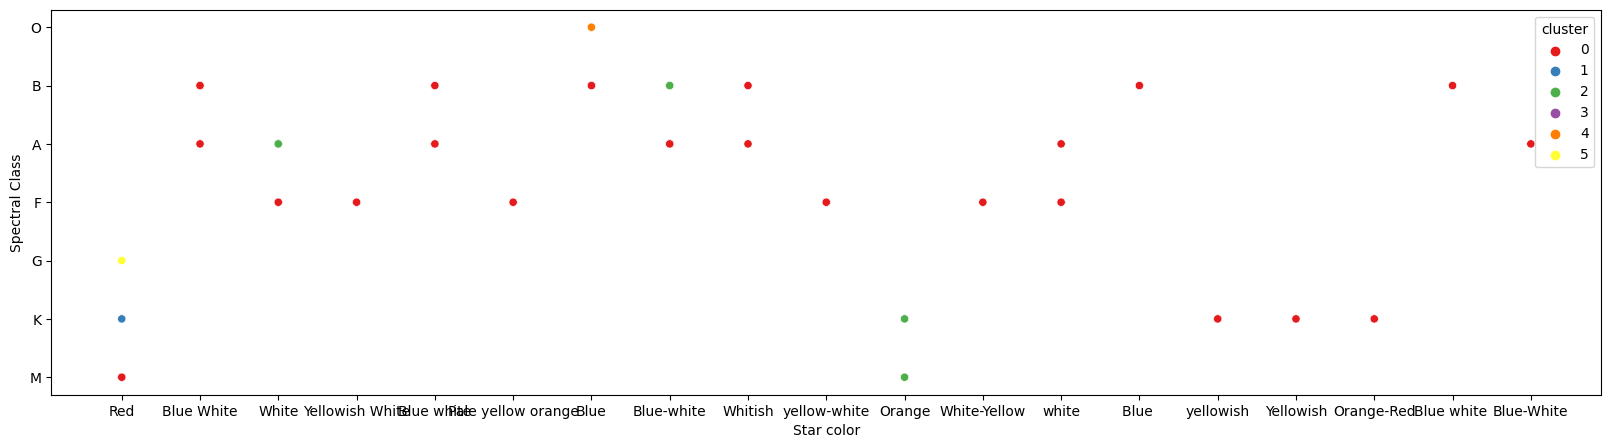

In [110]:
fig = plt.figure(figsize = (20,5))
ax = fig.gca()

sns.scatterplot(data=df,x='Star color',y='Spectral Class',hue='cluster',palette="Set1",ax=ax)